### Import Dependencies

In [1]:
import random
random.seed(0)

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

### Constant Variables

In [3]:
DATASET_PATH = './knee-osteoarthritis_2'

In [4]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [6]:
classes = range(4)

### Dataset 

In [7]:
from src.dataset.augmented_dataset import get_KneeOsteoarthritis_Edges, KneeOsteoarthritis_Edges

transform_toTensor = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val_dataset = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)
test_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform_toTensor)

dataset_all = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [0.7, 0.1, 0.2])
train_dataset = KneeOsteoarthritis_Edges(train_dataset)
val_dataset = KneeOsteoarthritis_Edges(val_dataset)
test_dataset = KneeOsteoarthritis_Edges(test_dataset)

In [8]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

4736 676 1353


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

In [10]:
row = train_dataset[1]
normal_ex = row[0]
augmented_ex = row[1]
print(normal_ex.shape, augmented_ex.shape)

torch.Size([3, 256, 256]) torch.Size([1, 224, 224])


### Data Loader

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [12]:
class IntermediarySpaceModel(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        # Size of layer block
        S = 24
        
        # Images
        self.imagesClassifier = nn.Sequential(
            nn.Conv2d(3, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.2),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 7 * 7, S*2),
        )

        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(1, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 6 * 6, S*2),
        )
        
        self.outputCombiner = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*4, S*3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*3, S),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S, num_classes),
        )

    def forward(self, images: torch.Tensor, edges: torch.Tensor) -> torch.Tensor:
        
        # Images
        images = self.imagesClassifier(images)
        
        # Edges
        edges = self.edgesClassifier(edges)
        
        # Combining outputs
        concated = torch.cat((images, edges), 1)
        res = self.outputCombiner(concated)
        
        return res

In [13]:
# from src.models.custom import CustomModel

# model = EarlyIntermediarySpaceModel(3, 0)
model = IntermediarySpaceModel(4, 0.5)
model = model.to(device)

In [14]:
# print(sum(p.numel() for p in net.classifier.parameters()) ,sum(p.numel() for p in net.edgesClassifier.parameters()) )
print(sum(p.numel() for p in model.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(sum(p.numel() for p in trainable_parameters))

287044
287044


### Training Loop

#### Setting optimizer

In [15]:
import torch.optim as optim
from src.other import getClassesFrequency

class_weights = getClassesFrequency(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(class_weights, weights_tensor)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

{0: 2259, 1: 1514, 3: 185, 2: 778} tensor([2259., 1514.,  185.,  778.], device='cuda:0')


In [16]:
# decayRate100 = 0.8
decayRate100 = 0.4
decayRate1 = decayRate100**(1/100)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate1)

print(decayRate1)

0.9908789441918076


In [17]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

#### Setting Logger

In [18]:
EXP_NAME = "long_cm"

from torch.utils.tensorboard import SummaryWriter

logger = SummaryWriter(log_dir=f"logs/experiments/{EXP_NAME}")

In [19]:
epochCounter = 0

#### Training Loop

In [20]:
from src.evaluate import evaluate_augmented_model
from src.other import getConfusionMatrixDisplay

def train_many(model, epochs_nr, logger = None, lr_scheduler = None, regularization_type = "L2", lambda_reg=0.01, display_logs=False):
    global epochCounter
    
    for epoch in range(0, epochs_nr):  # loop over the dataset multiple times
        epoch_correct = 0
        epoch_samples = 0
        epoch_batches = 0
        running_loss = 0.0
    
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            images, edges, labels = data
            images = images.to(device)
            edges = edges.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(images, edges)
            loss = criterion(outputs, labels)
            
            # Apply L1 regularization
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
                
            # Apply L2 regularization
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm
                
            loss.backward()
            
            optimizer.step()
            
            # Changing outputs (logits) to labels
            outputs_clear = outputs.max(1).indices
            
            epoch_correct += (outputs_clear == labels).float().sum()
            epoch_samples += len(outputs)
            epoch_batches +=1
            
            running_loss += loss.item()
        
        tAccuracy = epoch_correct / epoch_samples * 100
        tLoss = running_loss / epoch_batches
        
        # Validation
        vAccuracy, vLoss, report, cm = evaluate_augmented_model(model, criterion, val_loader, device)
        # cmDisplay = getConfusionMatrixDisplay(cm, classes)
        
        learning_rate = get_lr(optimizer)
        if logger != None:

            # logger.add("Confusion_matrix", regularization_type, global_step=epochCounter)
            logger.add_text("REGULARIZATION_TYPE", regularization_type, global_step=epochCounter)
            logger.add_scalar("REGULARIZATION_LAMBDA", lambda_reg, global_step=epochCounter)
            logger.add_scalar("learning_rate", learning_rate, global_step=epochCounter)
            
            logger.add_scalar("Accuracy/train", tAccuracy, global_step=epochCounter)
            logger.add_scalar("Loss/train", tLoss, global_step=epochCounter)
            logger.add_scalar("Accuracy/validation", vAccuracy, global_step=epochCounter)
            logger.add_scalar("Loss/validation", vLoss, global_step=epochCounter)
            
            if epochCounter % 10 == 0:
                logger.add_text("Slassification Report", report, global_step=epochCounter)
                logger.add_figure("Confusion matrix", getConfusionMatrixDisplay(trainloader, classes), global_step=epochCounter)
                
                if display_logs:
                    getConfusionMatrixDisplay(trainloader, classes)
            
        print(f'Epoch {epochCounter}: Training: accuracy: {tAccuracy:.3f}%, loss: {tLoss:.3f}; Validation: accuracy: {vAccuracy:.3f}%, loss: {vLoss:.3f}, lr: {learning_rate:.5f}')
        
        epochCounter += 1
        
        if lr_scheduler != None:
            lr_scheduler.step()
        
        # print("lr= " + str(learning_rate))
    print('Finished Training')

#### Data Visualization

In [21]:
def visualize_cm(cm):
    getConfusionMatrixDisplay(cm, classes)
    plt.show()
    
def visualize_all(model, criterion, loader):
    acc, loss, report, cm = evaluate_augmented_model(model, criterion, loader, device)
    print(f"Accuracy: {acc}, loss: {loss}")
    print(report)
    
    visualize_cm(cm)

### Training Model

In [22]:
train_many(model, 100, None, my_lr_scheduler, "L2", 0.008)

Epoch 0: Training: accuracy: 40.203%, loss: 2.179; Validation: accuracy: 51.331%, loss: 0.969, lr: 0.00100
Epoch 1: Training: accuracy: 47.698%, loss: 1.457; Validation: accuracy: 51.331%, loss: 0.717, lr: 0.00099
Epoch 2: Training: accuracy: 47.698%, loss: 1.329; Validation: accuracy: 51.331%, loss: 0.718, lr: 0.00098
Epoch 3: Training: accuracy: 47.698%, loss: 1.228; Validation: accuracy: 51.331%, loss: 0.788, lr: 0.00097
Epoch 4: Training: accuracy: 47.698%, loss: 1.137; Validation: accuracy: 51.331%, loss: 0.591, lr: 0.00096
Epoch 5: Training: accuracy: 47.698%, loss: 1.063; Validation: accuracy: 51.331%, loss: 0.624, lr: 0.00096
Epoch 6: Training: accuracy: 47.698%, loss: 1.008; Validation: accuracy: 51.331%, loss: 0.559, lr: 0.00095
Epoch 7: Training: accuracy: 48.480%, loss: 0.959; Validation: accuracy: 52.219%, loss: 0.695, lr: 0.00094
Epoch 8: Training: accuracy: 52.492%, loss: 0.908; Validation: accuracy: 55.917%, loss: 0.484, lr: 0.00093
Epoch 9: Training: accuracy: 57.390%,

Accuracy: 96.76942567567568, loss: 0.01707095094025135
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2259
           1       0.96      1.00      0.98      1514
           2       1.00      0.80      0.89       778
           3       0.81      1.00      0.90       185

    accuracy                           0.97      4736
   macro avg       0.94      0.95      0.94      4736
weighted avg       0.97      0.97      0.97      4736



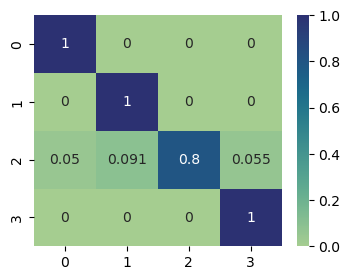

Accuracy: 66.51884700665188, loss: 1.7496623992919922
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       647
           1       0.57      0.57      0.57       450
           2       0.62      0.43      0.51       215
           3       0.42      0.54      0.47        41

    accuracy                           0.67      1353
   macro avg       0.59      0.59      0.58      1353
weighted avg       0.66      0.67      0.66      1353



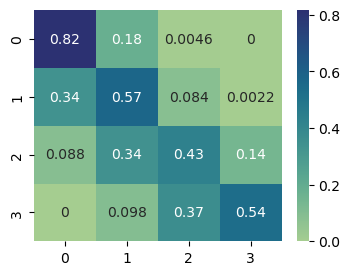

In [23]:
# test
visualize_all(model, criterion, train_loader)
visualize_all(model, criterion, test_loader)

In [24]:
train_many(model, 100, None, my_lr_scheduler, "L2", 0.008)

Epoch 100: Training: accuracy: 96.474%, loss: 0.126; Validation: accuracy: 66.124%, loss: 1.723, lr: 0.00040
Epoch 101: Training: accuracy: 96.643%, loss: 0.125; Validation: accuracy: 66.420%, loss: 1.783, lr: 0.00040
Epoch 102: Training: accuracy: 96.727%, loss: 0.124; Validation: accuracy: 65.828%, loss: 1.047, lr: 0.00039
Epoch 103: Training: accuracy: 96.537%, loss: 0.124; Validation: accuracy: 66.272%, loss: 1.663, lr: 0.00039
Epoch 104: Training: accuracy: 96.938%, loss: 0.123; Validation: accuracy: 66.568%, loss: 1.041, lr: 0.00039
Epoch 105: Training: accuracy: 97.044%, loss: 0.122; Validation: accuracy: 66.568%, loss: 0.628, lr: 0.00038
Epoch 106: Training: accuracy: 97.023%, loss: 0.122; Validation: accuracy: 66.716%, loss: 1.333, lr: 0.00038
Epoch 107: Training: accuracy: 96.833%, loss: 0.122; Validation: accuracy: 66.864%, loss: 1.331, lr: 0.00038
Epoch 108: Training: accuracy: 96.981%, loss: 0.121; Validation: accuracy: 67.012%, loss: 1.607, lr: 0.00037
Epoch 109: Training

Accuracy: 98.58530405405405, loss: 0.010875229723751545
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2259
           1       0.97      1.00      0.98      1514
           2       1.00      0.91      0.96       778
           3       0.99      1.00      1.00       185

    accuracy                           0.99      4736
   macro avg       0.99      0.98      0.98      4736
weighted avg       0.99      0.99      0.99      4736



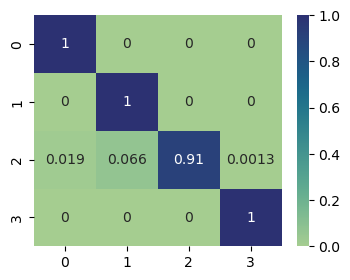

Accuracy: 66.22320768662232, loss: 1.5146923065185547
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       647
           1       0.55      0.59      0.57       450
           2       0.63      0.41      0.50       215
           3       0.50      0.39      0.44        41

    accuracy                           0.66      1353
   macro avg       0.61      0.55      0.57      1353
weighted avg       0.66      0.66      0.66      1353



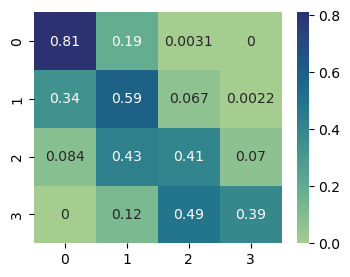

In [26]:
visualize_all(model, criterion, train_loader)
visualize_all(model, criterion, test_loader)

In [27]:
train_many(model, 100, None, my_lr_scheduler, "L2", 0.008)

Epoch 200: Training: accuracy: 99.155%, loss: 0.101; Validation: accuracy: 66.124%, loss: 1.446, lr: 0.00016
Epoch 201: Training: accuracy: 99.430%, loss: 0.100; Validation: accuracy: 65.089%, loss: 1.537, lr: 0.00016
Epoch 202: Training: accuracy: 99.430%, loss: 0.100; Validation: accuracy: 65.533%, loss: 2.179, lr: 0.00016
Epoch 203: Training: accuracy: 99.430%, loss: 0.100; Validation: accuracy: 66.420%, loss: 2.479, lr: 0.00016
Epoch 204: Training: accuracy: 99.451%, loss: 0.100; Validation: accuracy: 65.828%, loss: 2.820, lr: 0.00015
Epoch 205: Training: accuracy: 99.451%, loss: 0.099; Validation: accuracy: 65.533%, loss: 0.710, lr: 0.00015
Epoch 206: Training: accuracy: 99.451%, loss: 0.099; Validation: accuracy: 65.680%, loss: 1.469, lr: 0.00015
Epoch 207: Training: accuracy: 99.451%, loss: 0.099; Validation: accuracy: 65.385%, loss: 1.206, lr: 0.00015
Epoch 208: Training: accuracy: 99.472%, loss: 0.099; Validation: accuracy: 65.976%, loss: 1.514, lr: 0.00015
Epoch 209: Training

Accuracy: 99.83108108108108, loss: 0.006297830492258072
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2259
           1       1.00      1.00      1.00      1514
           2       1.00      0.99      0.99       778
           3       0.99      1.00      1.00       185

    accuracy                           1.00      4736
   macro avg       1.00      1.00      1.00      4736
weighted avg       1.00      1.00      1.00      4736



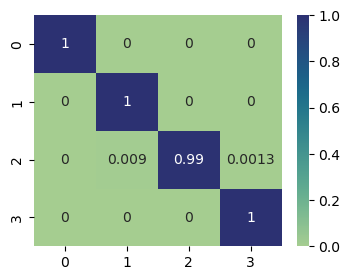

Accuracy: 64.7450110864745, loss: 1.0578800439834595
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       647
           1       0.53      0.58      0.56       450
           2       0.62      0.47      0.53       215
           3       0.48      0.49      0.48        41

    accuracy                           0.65      1353
   macro avg       0.59      0.57      0.58      1353
weighted avg       0.65      0.65      0.65      1353



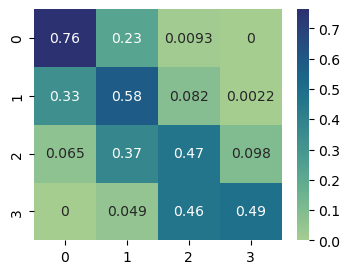

In [30]:
visualize_all(model, criterion, train_loader)
visualize_all(model, criterion, test_loader)